### Ukázka K-Means pro semi-supervised learning

In [1]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)

In [2]:
X_digits.shape

(1797, 64)

In [3]:
X_digits[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

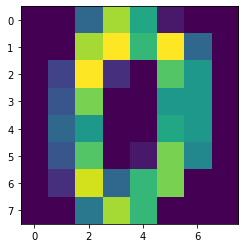

In [4]:
from matplotlib import pyplot as plt

plt.imshow(X_digits[0].reshape(8,8))

Oddělíme testovací data

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, 
                                                    random_state=42)

#### Varianta A - naivní

Máme celý dataset příznaků, ale žádné labely. Rozhodneme se, že zainvestujeme do získání 50 labelů. Instance vybereme náhodně 

In [6]:
n_labeled = 50


### Dataset je náhodně zamíchaný, takže prvních 50 splní účel

X_train_labeled = X_train[:n_labeled]

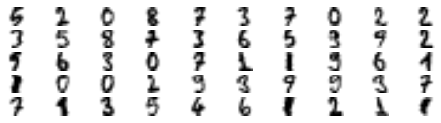

In [7]:
plt.figure(figsize=(8, 2))
for index, digit in enumerate(X_train_labeled):
    plt.subplot(n_labeled // 10, 10, index + 1)
    plt.imshow(digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

In [8]:
### Zde si zjednodušíme život - "ukradneme" labely z datasetu.
y_train_labeled = y_train[:n_labeled]
y_train_labeled

array([5, 2, 0, 8, 7, 3, 7, 0, 2, 2, 3, 5, 8, 7, 3, 6, 5, 9, 9, 2, 5, 6,
       3, 0, 7, 1, 1, 9, 6, 1, 1, 0, 0, 2, 9, 3, 9, 9, 3, 7, 7, 1, 3, 5,
       4, 6, 1, 2, 1, 1])

In [9]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
logreg.fit(X_train_labeled, y_train_labeled)
logreg.score(X_test, y_test)

0.8333333333333334

Výsledek metriky accuracy máme 83 %.

In [10]:
### potlačíme otravné warningy
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Varianta B - výběr reprezentativních instancí pomocí clusterů

Shlukneme training set do 50 clusterů. Pro každý cluster najdeme instanci, která je nejblíž jeho centroidu. Tyto instance nazveme jako reprezentativní instance. 

In [11]:
import numpy as np
from sklearn.cluster import KMeans

k = 50
kmeans = KMeans(n_clusters=k, random_state=42)

X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

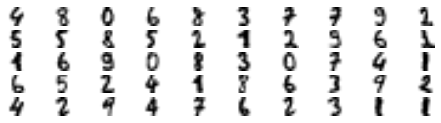

In [12]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

Teď musíme ručně nachystat labely

In [13]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

In [14]:
### nebo je pro jednoduchost můžeme zase vzít z datasetu
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

Máme tedy reprezentativní obrázky jednotlivých clusterů, vyzkoušíme jak si vede klasifikátor

In [15]:
logreg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
logreg.fit(X_representative_digits, y_representative_digits)
logreg.score(X_test, y_test)

0.9222222222222223

Výběrem reprezentativních instancí jsme zlepšili správnost klasifikátoru z 83 % na 92 %, a to při stejném množství lidské práce.

### Varianta C - propagace labelů pro instance uvnitř clusterů 

Řekneme, že chceme labely propagovat pro instance, které jsou uvnitř clusterů (několik % instancí nejbližších centroidu u kterých lze předpokládat, že budou opravdu patřit k dané třídě)

In [16]:
percentile_closest = 18

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [17]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [18]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [19]:
logreg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
logreg.fit(X_train_partially_propagated, y_train_partially_propagated)
logreg.score(X_test, y_test)

0.9488888888888889

S tímto řešením jsme se dostali na správnost téměř 95 % oproti původním 83 %, a to při stejném množství lidské práce.

### Varianta D - pro porovnání, necháme zaplatit přiřazení labelů do celého datasetu

In [20]:
logreg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.9688888888888889

Pokud bychom měli celý dataset včetně labelů, dostaneme se na necelých 97 % při 36násobném množství práce 

### Active Learning - aneb jak pokračovat dál

Model je natrénován pomocí ručního označkování 50 instancí. Pak ho necháme dělat predikce. Instance, pro které si je model málo jistý svou predikcí, jsou předány člověku, aby k nim přiřadil labely.

Takto se pokračuje pořád dál, dokud zlepšování klasifikátoru stojí za lidskou práci, která je k tomuto procesu nutná.

In [21]:
probas = np.amax(logreg.predict_proba(X_test), axis=1)
idxs = np.argsort(probas)
idxs

array([177, 166, 100,  94, 240, 322, 401, 321, 179, 431, 444, 270,   1,
       346,  97, 139, 410, 339, 394, 399,   5, 164,  78,  60, 372, 201,
       249, 425, 426, 159,  92, 169, 352, 222, 248, 136, 415,  81, 259,
        96, 151, 185, 400, 144, 129, 320, 244, 334, 193, 374, 214, 297,
       101, 149, 314, 157, 113,   9, 324, 234, 116, 315, 226, 366, 105,
       318, 448, 414, 443, 442, 365, 235, 340, 143, 256, 239, 391,  24,
       223, 150, 305, 115, 254, 284, 184,  36,  99,  90, 232, 267,  11,
       233, 156, 121, 377, 133, 342, 302,  10, 369, 396,  54, 152, 349,
       360,  67, 124,  89,  62, 272,  42,  71, 333, 327,  25, 198, 262,
       325, 371,  51, 174, 422,  33,  56,  64, 317, 225, 146,   3, 242,
        35, 424,  18,  39, 227, 173,  53,  32, 264,  59,  77, 102, 344,
       291, 296, 204, 142, 345, 286,  57,  49, 418, 231, 383,  44, 202,
       405, 319, 293, 200, 216, 393,  98, 218, 347,  26, 135, 330, 358,
       228, 303, 445, 341, 103, 260,  75, 220, 186,  14,  50, 44

In [22]:
probas[idxs]

array([0.50014609, 0.50266953, 0.51018638, 0.51286915, 0.51335078,
       0.52114843, 0.5232262 , 0.52518705, 0.53060336, 0.55101027,
       0.5572589 , 0.56883217, 0.58905309, 0.59167143, 0.60366095,
       0.60966707, 0.61087576, 0.62629114, 0.63122424, 0.63500728,
       0.64347961, 0.6469217 , 0.65222958, 0.65465029, 0.66237582,
       0.68642955, 0.70466329, 0.70823834, 0.71061204, 0.72321311,
       0.72648388, 0.72794455, 0.73096278, 0.73937612, 0.75645715,
       0.75922811, 0.78085909, 0.79040329, 0.80735763, 0.81174461,
       0.81407236, 0.81490366, 0.81857992, 0.82606841, 0.83908339,
       0.84433271, 0.84621678, 0.84670831, 0.84708492, 0.85657552,
       0.86040639, 0.86182273, 0.86406861, 0.87598993, 0.87931741,
       0.88584025, 0.8868756 , 0.89052081, 0.90084719, 0.90344038,
       0.90620361, 0.91026596, 0.91057182, 0.92158693, 0.92224544,
       0.92433411, 0.9247413 , 0.92638033, 0.92901387, 0.93501816,
       0.93624589, 0.93635479, 0.93652771, 0.93756524, 0.94045